# ***Why?***

We're trying to predict what different peptides (small protein molecules) can do in the body, how can they affect it.



We have thousands of peptides (like small pieces of proteins).
Each peptide can have multiple different functions (like "can kill bacteria" or "can reduce inflammation").



**The goal here is simple - given a new peptide, predict what functions it might have.**


  We are predicting peptide properties using molecular fingerprints. This has significant implications in drug discovery and development, as it can help researchers identify potential drug candidates more efficiently.


In [1]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.3/286.3 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 713.7/713.7 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2

In [3]:
from skfp.datasets.lrgb import load_peptides_func

seq, y = load_peptides_func(mol_type = "aminoseq")

print(f"Example molecule: {seq[0]}")
print(f"Example class: {y[3]}")


Example molecule: VKLkVyPLKVKLyP
Example class: [0 0 0 0 0 0 0 0 0 1]


In [4]:
import numpy as np
from sklearn.model_selection import train_test_split


X_train, X_val, y_train, y_val = train_test_split(
    seq,
    y,
    test_size=0.2,

    random_state=42
)

print(len(X_train))
print(len(X_val))

12428
3107


example peptide:


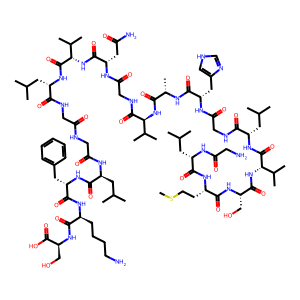

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [8]:
from skfp.fingerprints import ECFPFingerprint
from skfp.fingerprints import TopologicalTorsionFingerprint
from skfp.fingerprints import EStateFingerprint
from skfp.preprocessing import MolFromAminoseqTransformer
from sklearn.pipeline import FeatureUnion

# Convert sequences to mols
mol_transformer = MolFromAminoseqTransformer()
X_train_mols = mol_transformer.transform(X_train)
X_val_mols = mol_transformer.transform(X_val)

#example peptide:
from rdkit.Chem.Draw import MolToImage
img = MolToImage(X_train_mols[5])
print("example peptide:")
display(img)


# Filter out None values, because error was raised
X_train_mols = [mol for mol in X_train_mols if mol is not None]
y_train = y_train[[i for i, mol in enumerate(X_train_mols) if mol is not None]]

X_val_mols = [mol for mol in X_val_mols if mol is not None]
y_val = y_val[[i for i, mol in enumerate(X_val_mols) if mol is not None]]


#Lets try to use multiple fingerprints
fps = FeatureUnion([
    ('ecfp', ECFPFingerprint(radius=2)),
    ('tt', TopologicalTorsionFingerprint()),
    ('estate', EStateFingerprint())
])
# fp = ECFPFingerprint(radius=2, n_jobs=-1)
fp = EStateFingerprint(n_jobs=-1)

X_train_fp = fp.transform(X_train_mols)

# Transform our molecules into fingerprints

X_val_fp = fp.transform(X_val_mols)





In [10]:
from skfp.metrics import multioutput_auprc_score
from sklearn.ensemble import RandomForestClassifier

# Let's say we have trained a classifier
clf = RandomForestClassifier(n_jobs=-1, random_state=0)
clf.fit(X_train_fp, y_train)

# Get probability predictions
# This will give probabilities for each class for each task
y_pred_proba = clf.predict_proba(X_val_fp)

# Important: we need to extract positive class probabilities only
# Because y_score needs to be probability of positive class
y_score = np.array([probs[:, 1] for probs in y_pred_proba]).T

# Calculate score
score = multioutput_auprc_score(y_val, y_score)
print(f"AUPRC Score: {score:.3f}")

AUPRC Score: 0.168
